# Keras
## 1. Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

2021-11-13 14:10:26.949098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-13 14:10:26.949125: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# layers can be used on its own
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))

# but more convenient to arrange layers into one structure: 
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),  
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)

# or build a Sequential model incrementally:
model = keras.Sequential(name="my_sequential")
model.add(layers.Dense(2, activation="relu", name="layer1"))
model.add(layers.Dense(3, activation="relu", name="layer2"))
model.add(layers.Dense(4, name="layer3"))
model.pop()

Generally, all layers in Keras need to know the shape of their inputs in order to be able to create their weights. <br>
Same goes for Sequential models.

In [10]:
# print(model.weights)  <-- this will rise an exception at this point

x = tf.ones((3, 3))
y = model(x)

print(model.weights)

[<tf.Variable 'layer1/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.11087352,  0.03812969],
       [-0.14834762,  0.98491645],
       [-0.72513294,  1.0153396 ]], dtype=float32)>, <tf.Variable 'layer1/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>, <tf.Variable 'layer2/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[-0.07539117,  0.06727755, -0.27315062],
       [-0.72855663, -0.47973704,  1.0551903 ]], dtype=float32)>, <tf.Variable 'layer2/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [11]:
# investigate different aspects of the model
model.layers
model.weights
len(model.layers)
len(model.weights)

model.summary()

Model: "my_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (3, 2)                    8         
                                                                 
 layer2 (Dense)              (3, 3)                    9         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


When building a Sequential model incrementally, you'd want to be able to investigate a partially built model.<br>
To do that, specify weights size in advance.

In [12]:
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu", input_shape=(4,))) # batch size is always omitted

# or:
model = keras.Sequential()
model.add(keras.Input(shape=(4,)))
model.add(layers.Dense(2, activation="relu"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Note that the Input object is not displayed as part of model.layers, since it isn't a layer.<br>
It is best practice to **always specify the input shape** of a Sequential model in advance if you know what it is.

Once a Sequential model has been built, it behaves like a Functional API model. This means that every layer has an input and output attribute. These attributes can be used to do neat things, like quickly creating a model that extracts the outputs of all intermediate layers in a Sequential model:

In [ ]:
initial_model = keras.Sequential(
    [
        keras.Input(shape=(250, 250, 3)),
        layers.Conv2D(32, 5, strides=2, activation="relu"),
        layers.Conv2D(32, 3, activation="relu", name="my_intermediate_layer"),
        layers.Conv2D(32, 3, activation="relu"),
    ]
)
feature_extractor = keras.Model(
    inputs=initial_model.inputs,
    outputs=initial_model.get_layer(name="my_intermediate_layer").output,
)
# or:
feature_extractor = keras.Model(
    inputs=initial_model.inputs,
    outputs=[layer.output for layer in initial_model.layers],
)

# Call feature extractor on test input.
x = tf.ones((1, 250, 250, 3))
features = feature_extractor(x)

### Transfer learning with a Sequential model

In [ ]:
# 1 option
model = keras.Sequential([
    keras.Input(shape=(784)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10),
])

model.load_weights(...)

# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

# 2 option
base_model = keras.applications.Xception(weights='imagenet', include_top=False, pooling='avg')
# Freeze the base model
base_model.trainable = False

# Use a Sequential model to add a trainable classifier on top
model = keras.Sequential([
    base_model,
    layers.Dense(1000),
])


# Compile & train
model.compile(...)
model.fit(...)

## 2. Functional API
In all other cases.<br>
The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

In [13]:
# It is generally recommend to use the Keras Functional model via Input, 
# (which creates an InputLayer) without directly using layers.InputLayer.
inputs = keras.Input(shape=(784,))

print(inputs.shape)
print(inputs.dtype)

(None, 784)
<dtype: 'float32'>


You create a new node in the graph of layers by calling a layer on this inputs object:

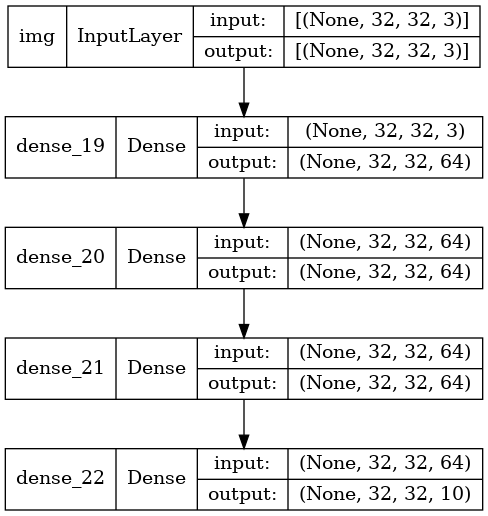

In [27]:
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
keras.utils.plot_model(model, "data/my_first_model.png", show_shapes=True)
#model.summary()

### Nested models
You can treat any model as if it were a layer by invoking it on an Input or on the output of another layer. <br>
By calling a model you aren't just reusing the architecture of the model, **you're also reusing its weights**.

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
#autoencoder.summary()

A common use case for model nesting is **ensembling**.

In [ ]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

### Non-linear topology
This is a very flexible way to create models, since you can create branches (by reusing same inputs), have multiple inputs etc.<br>

In [ ]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(32, 3, activation="relu", padding="same")(block_1_output)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(32, 3, activation="relu")(block_2_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
keras.utils.plot_model(model, "data/mini_resnet.png", show_shapes=True)
#model.summary()

### Shared layers
Shared layers are layer instances that are reused multiple times in the same model -- they learn features that correspond to multiple paths in the graph-of-layers.

In [ ]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequences of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

### Extract nodes in the graph of layers
This comes in handy for tasks like neural style transfer, among other things.

In [ ]:
vgg19 = tf.keras.applications.VGG19()
features_list = [layer.output for layer in vgg19.layers]

feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)


## 3. Subclassing Layers and Models
### Custom layers
All layers subclass the Layer class and implement:
 - `call()` method, that specifies the computation done by the layer.
 - `build()` method, that creates the weights of the layer (you can create weights in `__init__` as well, but then you'd have to specify or pass dimensions to the layer, instead of creating weights lazily some time after the layer has been instantiated).

For serialization support, also define a `get_config()` method that returns the constructor arguments of the layer instance


In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), 
            initializer="random_normal", 
            trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


liear_layer = CustomDense(10)   # __init___()

inputs = keras.Input((4,))
outputs = liear_layer(inputs)   # build()

model = keras.Model(inputs, outputs)
config = model.get_config()
new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

Layers are recursively composable. If you assign a Layer instance as an attribute of another Layer, the outer layer will start tracking the weights created by the inner layer.

We recommend creating such sublayers in the `__init__()` method and leave it to the first `__call__()` to trigger building their weights.

In [ ]:
class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = CustomDense(32)
        self.linear_2 = CustomDense(32)
        self.linear_3 = CustomDense(1)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)


mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))  # The first call to the `mlp` will create the weights
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))


#### add_loss()
These losses (including those created by any inner layer) can be retrieved via `layer.losses` which is reset at the start of every `__call__()` to the top-level layer, so that layer.losses always contains the loss values created during the last forward pass.

The loss property also contains regularization losses created for the weights of any inner layer.

In [ ]:
class ActivityRegularizationLayer(keras.layers.Layer):
    def __init__(self, rate=1e-2):
        super(ActivityRegularizationLayer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs

class OuterLayer(keras.layers.Layer):
    def __init__(self):
        super(OuterLayer, self).__init__()
        self.activity_reg = ActivityRegularizationLayer(1e-2)

    def call(self, inputs):
        return self.activity_reg(inputs)


layer = OuterLayer()
assert len(layer.losses) == 0  # No losses yet

_ = layer(tf.zeros(1, 1))
assert len(layer.losses) == 1  # created one loss value

_ = layer(tf.zeros(1, 1))
assert len(layer.losses) == 1  # the new loss


class OuterLayerWithKernelRegularizer(keras.layers.Layer):
    def __init__(self):
        super(OuterLayerWithKernelRegularizer, self).__init__()
        self.dense = keras.layers.Dense(
            32, kernel_regularizer=tf.keras.regularizers.l2(1e-3)
        )

    def call(self, inputs):
        return self.dense(inputs)


layer = OuterLayerWithKernelRegularizer()
_ = layer(tf.zeros((1, 1)))

# This is `1e-3 * sum(layer.dense.kernel ** 2)`, created by the `kernel_regularizer`.
print(layer.losses)


inputs = keras.Input(shape=(3,))
outputs = ActivityRegularizationLayer()(inputs)
model = keras.Model(inputs, outputs)
# you don't have to pass any loss in `compile`, since the model already has a loss
model.compile(optimizer="adam")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# If you do, the regularization losses get added to it
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

#### add_metric()

In [ ]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

layer = LogisticEndpoint()

targets = tf.ones((2, 2))
logits = tf.ones((2, 2))
y = layer(targets, logits)

print("layer.metrics:", layer.metrics)
print("current accuracy value:", float(layer.metrics[0].result()))

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

#### get_config()
to make your custom layers serializable as part of a Functional model

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        config = super(Linear, self).get_config()
        config.update({"units": self.units})
        return config


layer = Linear(64)
config = layer.get_config()
print(config)
new_layer = Linear.from_config(config)


If you need more flexibility when deserializing the layer from its config, you can also override the from_config() class method. This is the base implementation of from_config():

In [ ]:
def from_config(cls, config):
  return cls(**config)

#### Privileged training argument in the call() method

Some layers, in particular the BatchNormalization layer and the Dropout layer, have different behaviors during training and inference. For such layers, it is standard practice to expose a training (boolean) argument in the call() method.

By exposing this argument in call(), you enable the built-in training and evaluation loops (e.g. fit()) to correctly use the layer in training and inference.

In [ ]:
class CustomDropout(keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

#### Privileged mask argument in the call() method

The other privileged argument supported by call() is the mask argument.

You will find it in all Keras RNN layers. A mask is a boolean tensor (one boolean value per timestep in the input) used to skip certain input timesteps when processing timeseries data.

Keras will automatically pass the correct mask argument to __call__() for layers that support it, when a mask is generated by a prior layer. Mask-generating layers are the Embedding layer configured with mask_zero=True, and the Masking layer.

### Custom models
The Model class has the same API as Layer, with the following differences:

- It exposes built-in training, evaluation, and prediction loops (model.fit(), model.evaluate(), model.predict()).
- It exposes the list of its inner layers, via the model.layers property.
- It exposes saving and serialization APIs (save(), save_weights()...)

In general, the functional API is higher-level, easier and safer, and has a number of features that subclassed models do not support.

However, model subclassing provides greater flexibility when building models that are not easily expressible as directed acyclic graphs of layers. For example, you could not implement a Tree-RNN with the functional API and would have to subclass Model directly.

Functional API strengths:<br>
 - less verbose
 - Model validation while defining its connectivity graph
 - A functional model is plottable and inspectable
 - A functional model can be serialized or cloned

BUT:
- It does not support dynamic architectures

Note: All models in the tf.keras API can interact with each other, whether they're Sequential models, functional models, or subclassed models that are written from scratch.

In [ ]:
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

mlp = MLP()

# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))

The **call()** method should follow one of the following patterns:

    call(self, inputs, **kwargs)
    call(self, inputs, training=None, **kwargs)
    call(self, inputs, mask=None, **kwargs)
    call(self, inputs, training=None, mask=None, **kwargs)

inputs = tensor / nested structure of tensors, and **kwargs are non-tensor arguments<br>
training = boolean indicating training mode and inference mode<br>
mask = boolean tensor (useful for RNNs, for instance)<br>

Additionally, if you implement the get_config method on your custom Layer or model, the functional models you create will still be serializable and cloneable.

### Subclassing vs Functional API example

In [ ]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [ ]:
# Uses (z_mean, z_log_var) to sample z, the vector encoding a digit
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Maps MNIST digits to a triplet (z_mean, z_log_var, z)
class Encoder(layers.Layer):
    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

# Converts z, the encoded digit vector, back into a readable digit
class Decoder(layers.Layer):
    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(keras.Model):
    def __init__(self, original_dim, intermediate_dim=64, latent_dim=32,
        name="autoencoder", **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

original_dim = 784
intermediate_dim = 64
latent_dim = 32
vae = VariationalAutoEncoder(original_dim, intermediate_dim, latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=2, batch_size=64)

In [ ]:
original_dim = 784
intermediate_dim = 64
latent_dim = 32

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=3, batch_size=64)